# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 3 & 4
# Preliminaries operations

## Import needed libraries

In [1]:
#Import needed libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


## 0.1 Data preparation & standardization

In [2]:
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"], axis=1, inplace=True)
ddos_data_original = ddos_data.copy()
ddos_data = ddos_data.set_index('Flow ID')
print(ddos_data)
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state=15)
X_s = pca.fit_transform(X_s)


                                        Source Port  Destination Port  \
Flow ID                                                                 
172.16.0.5-192.168.50.1-634-60495-17            634             60495   
172.16.0.5-192.168.50.1-60495-634-17            634             60495   
172.16.0.5-192.168.50.1-634-46391-17            634             46391   
172.16.0.5-192.168.50.1-634-11894-17            634             11894   
172.16.0.5-192.168.50.1-634-27878-17            634             27878   
...                                             ...               ...   
172.16.0.5-192.168.50.1-38625-63051-17        38625             63051   
172.16.0.5-192.168.50.1-58632-18963-17        58632             18963   
172.16.0.5-192.168.50.1-46104-64704-17        46104             64704   
172.16.0.5-192.168.50.1-60686-10440-17        60686             10440   
172.16.0.5-192.168.50.1-45602-1387-17         45602              1387   

                                        Protocol  

# Section 3

The aim of this section is to find the best clustering algorithm with the best $k$.

## 1 Unsupervised Learning: K-means attempt
First of all, we define a function to perform k-means clustering and store metrics


In [4]:
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cl_labels = kmeans.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_
    return n_clusters, silhouette, ri, ari, inertia, cl_labels

In [5]:
%%time

# Arrays init
n_cluster_list_kmeans = []
shs_list_kmeans = []
ri_list_kmeans = []
ari_list_kmeans = []
inertia_list_kmeans = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list_kmeans, shs_list_kmeans, ri_list_kmeans, ari_list_kmeans, inertia_list_kmeans, tmp_kmeans = zip(
    *results_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_kmeans = np.max(shs_list_kmeans)
best_n_kmeans = n_cluster_list_kmeans[np.argmax(shs_list_kmeans)]
print("Best initial k: ", best_n_kmeans, " with corresponding silhouette: ", best_sh_kmeans)

# Refine search around the best k found
refined_n_cluster_list_kmeans = []
refined_shs_list_kmeans = []
refined_ri_list_kmeans = []
refined_ari_list_kmeans = []
refined_inertia_list_kmeans = []

# Define the refined range around the best k
refined_range = range(max(3, best_n_kmeans - 2), min(16, best_n_kmeans + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list_kmeans, refined_shs_list_kmeans, refined_ri_list_kmeans, refined_ari_list_kmeans, refined_inertia_list_kmeans, refined_cl_labels_list_kmeans = zip(
    *results_refined_kmeans)

# Get the best refined k
best_refined_sh_kmeans = np.max(refined_shs_list_kmeans)
best_refined_n_kmeans = refined_n_cluster_list_kmeans[np.argmax(refined_shs_list_kmeans)]
best_refined_kmeans = np.array([best_refined_sh_kmeans, best_refined_n_kmeans])
print("Best refined k: ", best_refined_n_kmeans, " with corresponding silhouette: ", best_refined_sh_kmeans)
# Best refined k:  11  with corresponding silhouette:  0.65934319268926

Best initial k:  9  with corresponding silhouette:  0.649110286518344
Best refined k:  11  with corresponding silhouette:  0.6593874731203916
CPU times: user 103 ms, sys: 281 ms, total: 384 ms
Wall time: 1min 53s


## 2 Unsupervised Learning: GMM attempt

First of all, we define a function to perform GMM clustering and store metrics


In [6]:
def perform_gmm_clustering(n_clusters, X_s, y, init_params):
    gmm = GaussianMixture(n_components=n_clusters, init_params=init_params, random_state=42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

### 2.1 First case: init_params='kmeans'

In [7]:
%%time
#In this case use as hyper-parameter init_params = kmeans

# Arrays init
n_cluster_list_gmm_kmeans = []
shs_list_gmm_kmeans = []
log_l_list_gmm_kmeans = []
ri_list_gmm_kmeans = []
ari_list_gmm_kmeans = []

# Use Parallel and delayed to parallelize the loop
results_gmm_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'kmeans') for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, ri_list_gmm_kmeans, ari_list_gmm_kmeans, log_l_list_gmm_kmeans = zip(
    *results_gmm_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_gmm_kmeans = np.max(shs_list_gmm_kmeans)
best_n_gmm_kmeans = n_cluster_list_gmm_kmeans[np.argmax(shs_list_gmm_kmeans)]
best_gmm_kmeans = np.array([best_sh_gmm_kmeans, best_n_gmm_kmeans])
print("best k: ", best_n_gmm_kmeans, " with corresponding silhouette: ", best_sh_gmm_kmeans)
# best k:  7  with corresponding silhouette:  0.6005188797984231

best k:  7  with corresponding silhouette:  0.6005188797984231
CPU times: user 33.1 ms, sys: 11.3 ms, total: 44.4 ms
Wall time: 57.2 s


#### Plots of Silhouette, Log-Likihood score and ARI

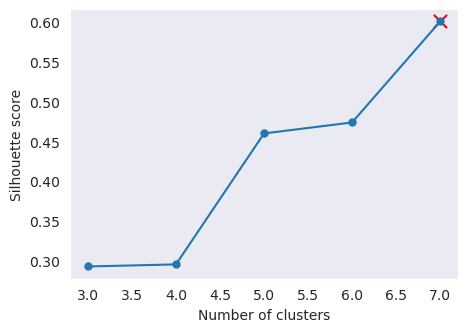

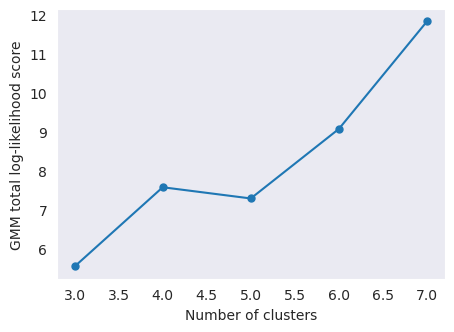

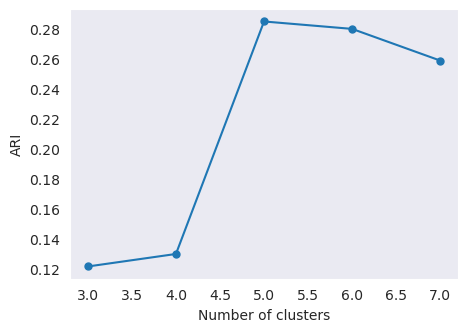

In [8]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, marker='o', markersize=5)
plt.scatter(best_n_gmm_kmeans, best_sh_gmm_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, log_l_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, ari_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()

### 2.2 Second case: init_params = random

In [9]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We compute the different scores for each iteration

#print(X_s)
#print(y)

# Arrays init
n_cluster_list_gmm_random = []
shs_list_gmm_random = []
ri_list_gmm_random = []
ari_list_gmm_random = []
log_l_list_gmm_random = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in initial_search_range)

n_cluster_list_gmm_random, shs_list_gmm_random, ri_list_gmm_random, ari_list_gmm_random, log_l_list_gmm_random = zip(
    *results_gmm_random)

# Find the best initial k
best_sh_gmm_random = np.max(shs_list_gmm_random)
best_n_gmm_random = n_cluster_list_gmm_random[np.argmax(shs_list_gmm_random)]

print("Best initial k: ", best_n_gmm_random, " with corresponding silhouette: ", best_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

# Refine search around the best k found
refined_n_cluster_list_gmm_random = []
refined_shs_list_gmm_random = []
refined_ri_list_gmm_random = []
refined_ari_list_gmm_random = []
refined_log_l_list_gmm_random = []

# Define the refined range
refined_range = range(max(3, best_n_gmm_random - 2), min(16, best_n_gmm_random + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in refined_range)

refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, refined_ri_list_gmm_random, refined_ari_list_gmm_random, refined_log_l_list_gmm_random = zip(
    *results_refined_gmm_random)

# Find the best refined k
best_refined_sh_gmm_random = np.max(refined_shs_list_gmm_random)
best_refined_n_gmm_random = refined_n_cluster_list_gmm_random[np.argmax(refined_shs_list_gmm_random)]
best_refined_gmm_random = np.array([best_refined_sh_gmm_random, best_refined_n_gmm_random])
print("Best refined k: ", best_refined_n_gmm_random, " with corresponding silhouette: ", best_refined_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

Best initial k:  3  with corresponding silhouette:  0.44878078445247965
Best refined k:  3  with corresponding silhouette:  0.44878078445247965
CPU times: user 64.3 ms, sys: 25.2 ms, total: 89.4 ms
Wall time: 1min 53s


#### Plots of Silhouette, Log-Likihood score and ARI


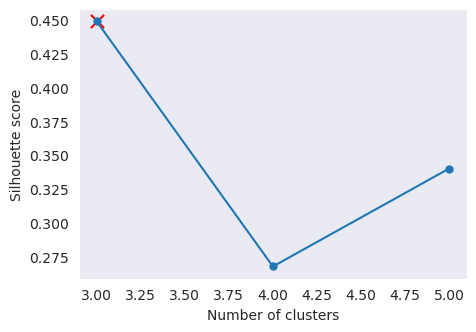

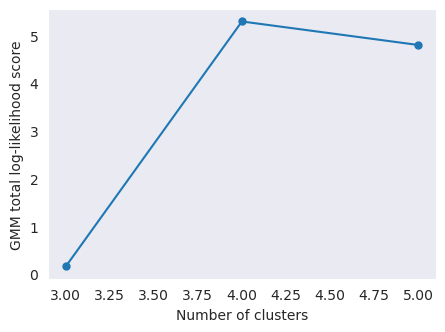

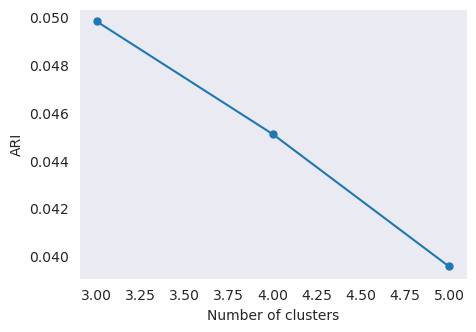

In [10]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, marker='o', markersize=5)
plt.scatter(best_refined_n_gmm_random, best_refined_sh_gmm_random, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_log_l_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_ari_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


In [11]:
%%time

# Plot ECDF per il numero di flussi per cluster
#plt.figure(figsize=(8, 5))
#sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
#plt.title('ECDF of Number of Flows per Cluster')
#plt.xlabel('Number of Flows')
#plt.ylabel('ECDF')
#plt.show()

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.54 µs


## Conclusions

In this section, we decide which is the best method of clustering, and with which k.

In [12]:
# Comparing the silhouette scores
scores = {
    "KMeans (Refined)": best_refined_kmeans[0],
    "GMM (KMeans Init)": best_gmm_kmeans[0],
    "GMM (Random Init)": best_refined_gmm_random[0]
}

# Find the algorithm with the highest score
best_algorithm = max(scores, key=scores.get)
best_score = scores[best_algorithm]

# Output the best algorithm and its score
print(f"The best clustering algorithm is {best_algorithm} with a silhouette score of {best_score}.")

# If needed, output the corresponding number of clusters
if best_algorithm == "KMeans (Refined)":
    best_n = best_refined_kmeans[1]
elif best_algorithm == "GMM (KMeans Init)":
    best_n = best_gmm_kmeans[1]
else:
    best_n = best_refined_gmm_random[1]

print(f"The optimal number of clusters for {best_algorithm} is {best_n}.")

The best clustering algorithm is KMeans (Refined) with a silhouette score of 0.6593874731203916.
The optimal number of clusters for KMeans (Refined) is 11.0.


# Section 4
## Do clusters reflect the GT labels ?

We use the data and the results of the k-means attempt

In [13]:
# Find the index of best_refined_n in refined_n_cluster_list

best_refined_index = refined_n_cluster_list_kmeans.index(best_refined_n_kmeans)

# Use this index to get the corresponding cluster labels
best_refined_cl_labels = refined_cl_labels_list_kmeans[best_refined_index]

# best_refined_cl_labels now contains the cluster labels for the best refined clustering
ddos_tmp = ddos_data_original.copy()
ddos_tmp['assigned_cluster'] = best_refined_cl_labels

# Group by 'label' and count unique clusters for each label
unique_clusters_per_label = ddos_tmp.groupby('label')['assigned_cluster'].nunique()

# Create a new DataFrame from the result
label_cluster_count_df = unique_clusters_per_label.reset_index()
label_cluster_count_df.columns = ['Label', 'Unique_Clusters_Count']

# 'label_cluster_count_df' now contains each label with the count of unique clusters associated with it
print(label_cluster_count_df)

           Label  Unique_Clusters_Count
0         benign                      9
1       ddos_dns                      8
2      ddos_ldap                      5
3     ddos_mssql                      4
4   ddos_netbios                      3
5       ddos_ntp                      6
6      ddos_snmp                      1
7      ddos_ssdp                      5
8       ddos_syn                      4
9      ddos_tftp                      5
10      ddos_udp                      3
11  ddos_udp_lag                      1


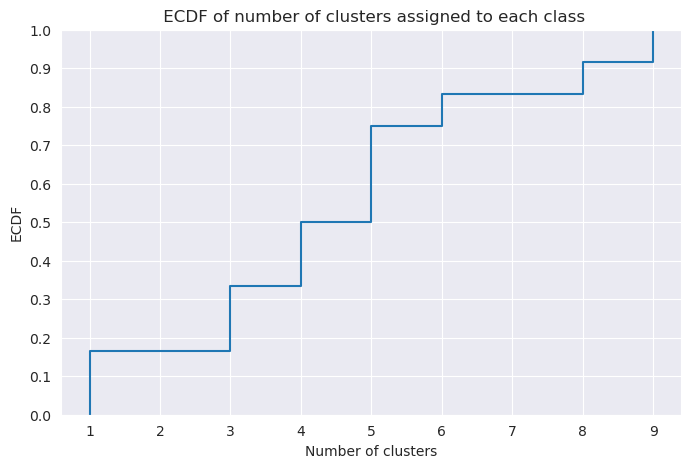

In [14]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

In [15]:
# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

Cluster 1 is not pure
Cluster 3 is not pure
Cluster 4 is not pure
Cluster 5 is not pure
Cluster 6 is pure
Cluster 8 is pure
Cluster 9 is pure


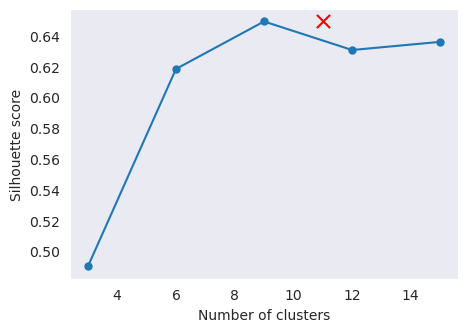

In [16]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_kmeans, shs_list_kmeans, marker='o', markersize=5)
plt.scatter(best_n, best_sh_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [17]:
%%time

# Utilizziamo quindi il modello KMeans

model = KMeans(n_clusters=best_refined_n_kmeans, random_state=42)

# Ottieni le etichette del cluster
cluster_labels = model.fit_predict(X_s)
print(cluster_labels)

# Calcola le metriche di clustering
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

# Stampa le metriche
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")

[7 7 6 ... 7 7 7]
Silhouette Score: 0.628177787915802
Adjusted Rand Index: 0.36347735038346574
CPU times: user 2min 35s, sys: 6min 55s, total: 9min 30s
Wall time: 1min 40s


## ECDF of number of clusters assigned to each class

In [18]:
%%time


# Analizza il numero di flussi per cluster
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 4.48 ms, sys: 1.18 ms, total: 5.67 ms
Wall time: 5.06 ms


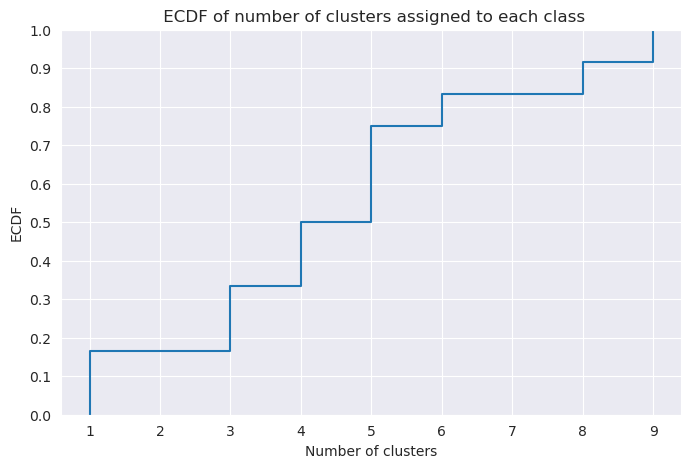

Cluster 1 is not pure
Cluster 3 is not pure
Cluster 4 is not pure
Cluster 5 is not pure
Cluster 6 is pure
Cluster 8 is pure
Cluster 9 is pure


In [19]:
# section 4
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")